In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

In [365]:
#directories
dataset_dir = 'dataset'
output_dir ="output"
g_matrix_filename = "G_ring.npy"

In [366]:
#store the computed images on disk
save_output = False

In [367]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [368]:
imgs = load_images_from_folder(dataset_dir)
n = len(imgs)

In [369]:
G = np.load(os.path.join(output_dir,g_matrix_filename))

In [370]:
i=0
j=0
print(G[3*i:3*(i+1),3*j:3*(j+1)])

[[-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]]


In [371]:
u,d,vh = np.linalg.svd(G)

In [372]:
v = vh.transpose()

In [373]:
print(G.shape, u.shape, d.shape, vh.shape)

(60, 60) (60, 60) (60,) (60, 60)


In [374]:
#u: left eigenvectors
#d: eigenvalues
#v: right eigenvectors

In [375]:
print(d)

[2.55850044e+03 2.55476413e+03 2.43716261e+03 2.42401507e+03
 2.13576895e+03 2.12575613e+03 1.90505684e+03 1.89457444e+03
 1.78064553e+03 1.77380471e+03 1.40863617e+03 1.40166746e+03
 1.11475798e+03 1.10897037e+03 8.68906578e+02 8.62516537e+02
 4.72456237e+02 4.68144005e+02 1.36924719e+02 1.30077046e+02
 3.89535625e+00 3.84540059e+00 3.70317724e+00 3.61800198e+00
 3.41536853e+00 3.17745387e+00 2.90887199e+00 2.62320040e+00
 2.31296574e+00 2.00889570e+00 1.68927565e+00 1.38534466e+00
 1.10137410e+00 1.04736739e+00 8.29152981e-01 5.86095706e-01
 3.75389288e-01 2.75011299e-01 1.59466849e-01 1.01862521e-01
 2.22027740e-02 1.39109828e-02 1.04775788e-02 8.66932620e-03
 5.07795224e-03 3.52341493e-03 3.09618730e-03 2.48733781e-03
 1.58080062e-03 1.30393653e-03 8.69390769e-04 6.01161882e-04
 3.74945338e-04 2.05570120e-04 1.09312151e-04 3.14956920e-05
 1.37829018e-05 2.14225974e-06 4.44406117e-07 1.63989466e-07]


In [376]:
np.argsort(d)

array([59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43,
       42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26,
       25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3,  2,  1,  0], dtype=int64)

In [377]:
# then find the three right singular vectors associated
# with the 3 smallest singular value, so the last 3 columns

In [378]:
# u_hat = np.dot( np.diag(np.sqrt(d)), v)[:,[-1,-2,-3]]

In [379]:
u_hat = v[:,[-1,-2,-3]]

In [380]:
u_hat.shape

(60, 3)

In [381]:
np.dot( u_hat.transpose(), u_hat)

array([[ 1.00000000e+00,  4.75547794e-16,  1.37125316e-17],
       [ 4.75547794e-16,  1.00000000e+00, -1.73114567e-16],
       [ 1.37125316e-17, -1.73114567e-16,  1.00000000e+00]])

In [382]:
def get_states(x):
    x_small = x.transpose()
    res = [ x_small[:,i*3:(i+1)*3].transpose() for i in range(x_small.shape[1]//3)]
    return res

In [383]:
U = get_states(u_hat)

In [319]:
H_new = [np.dot(U[0],np.linalg.inv(U[i])) for i in range(n)]

In [385]:
indx = 3

In [386]:
H = np.linalg.inv(H_new[indx])
img1 = imgs[indx]

In [387]:
(Height, Width, _) = img1.shape
    
# Taking the matrix of initial coordinates of the corners of the secondary image
# Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
# Where (xt, yt) is the coordinate of the i th corner of the image. 
InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                          [0, 0, Height - 1, Height - 1],
                          [1, 1, 1, 1]])

# Finding the final coordinates of the corners of the image after transformation.
# NOTE: Here, the coordinates of the corners of the frame may go out of the 
# frame(negative values). We will correct this afterwards by updating the 
# homography matrix accordingly.
FinalMatrix = np.dot(H, InitialMatrix)

[x, y, c] = FinalMatrix
x = np.divide(x, c)
y = np.divide(y, c)

In [388]:
x,y

(array([ 3819.60616545, 12595.22224841, 13015.52996566,  3860.01007476]),
 array([   -6.93054742, -1324.58770657,  3656.08790095,  1993.65321269]))

In [389]:
min_x = min(x)
min_y = min(y)

In [390]:
min_x,min_y

(3819.6061654540536, -1324.587706570757)

In [391]:
t = [-min_x,-min_y]
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

In [392]:
Ht

array([[ 1.00000000e+00,  0.00000000e+00, -3.81960617e+03],
       [ 0.00000000e+00,  1.00000000e+00,  1.32458771e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

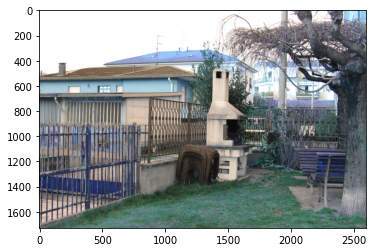

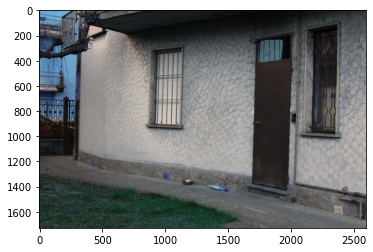

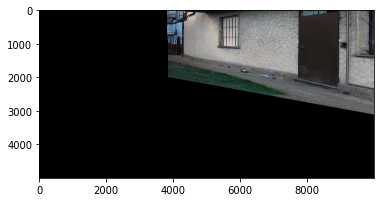

(<matplotlib.image.AxesImage at 0x1629b2f36a0>, None)

In [393]:
#i think H from img1 to img2

H_proj = np.dot(Ht,H)
size = img1.shape[0:2][::-1]
im_dst = cv.warpPerspective(img1, H, [10000,5000])
plt.imshow(imgs[0],),plt.show()
plt.imshow(img1,),plt.show()
plt.imshow(im_dst,),plt.show()

In [394]:
im_dst_base = cv.warpPerspective(imgs[0], np.linalg.inv(H_new[0]), [10000,5000])

In [395]:
stitch = np.maximum(im_dst_base,im_dst)

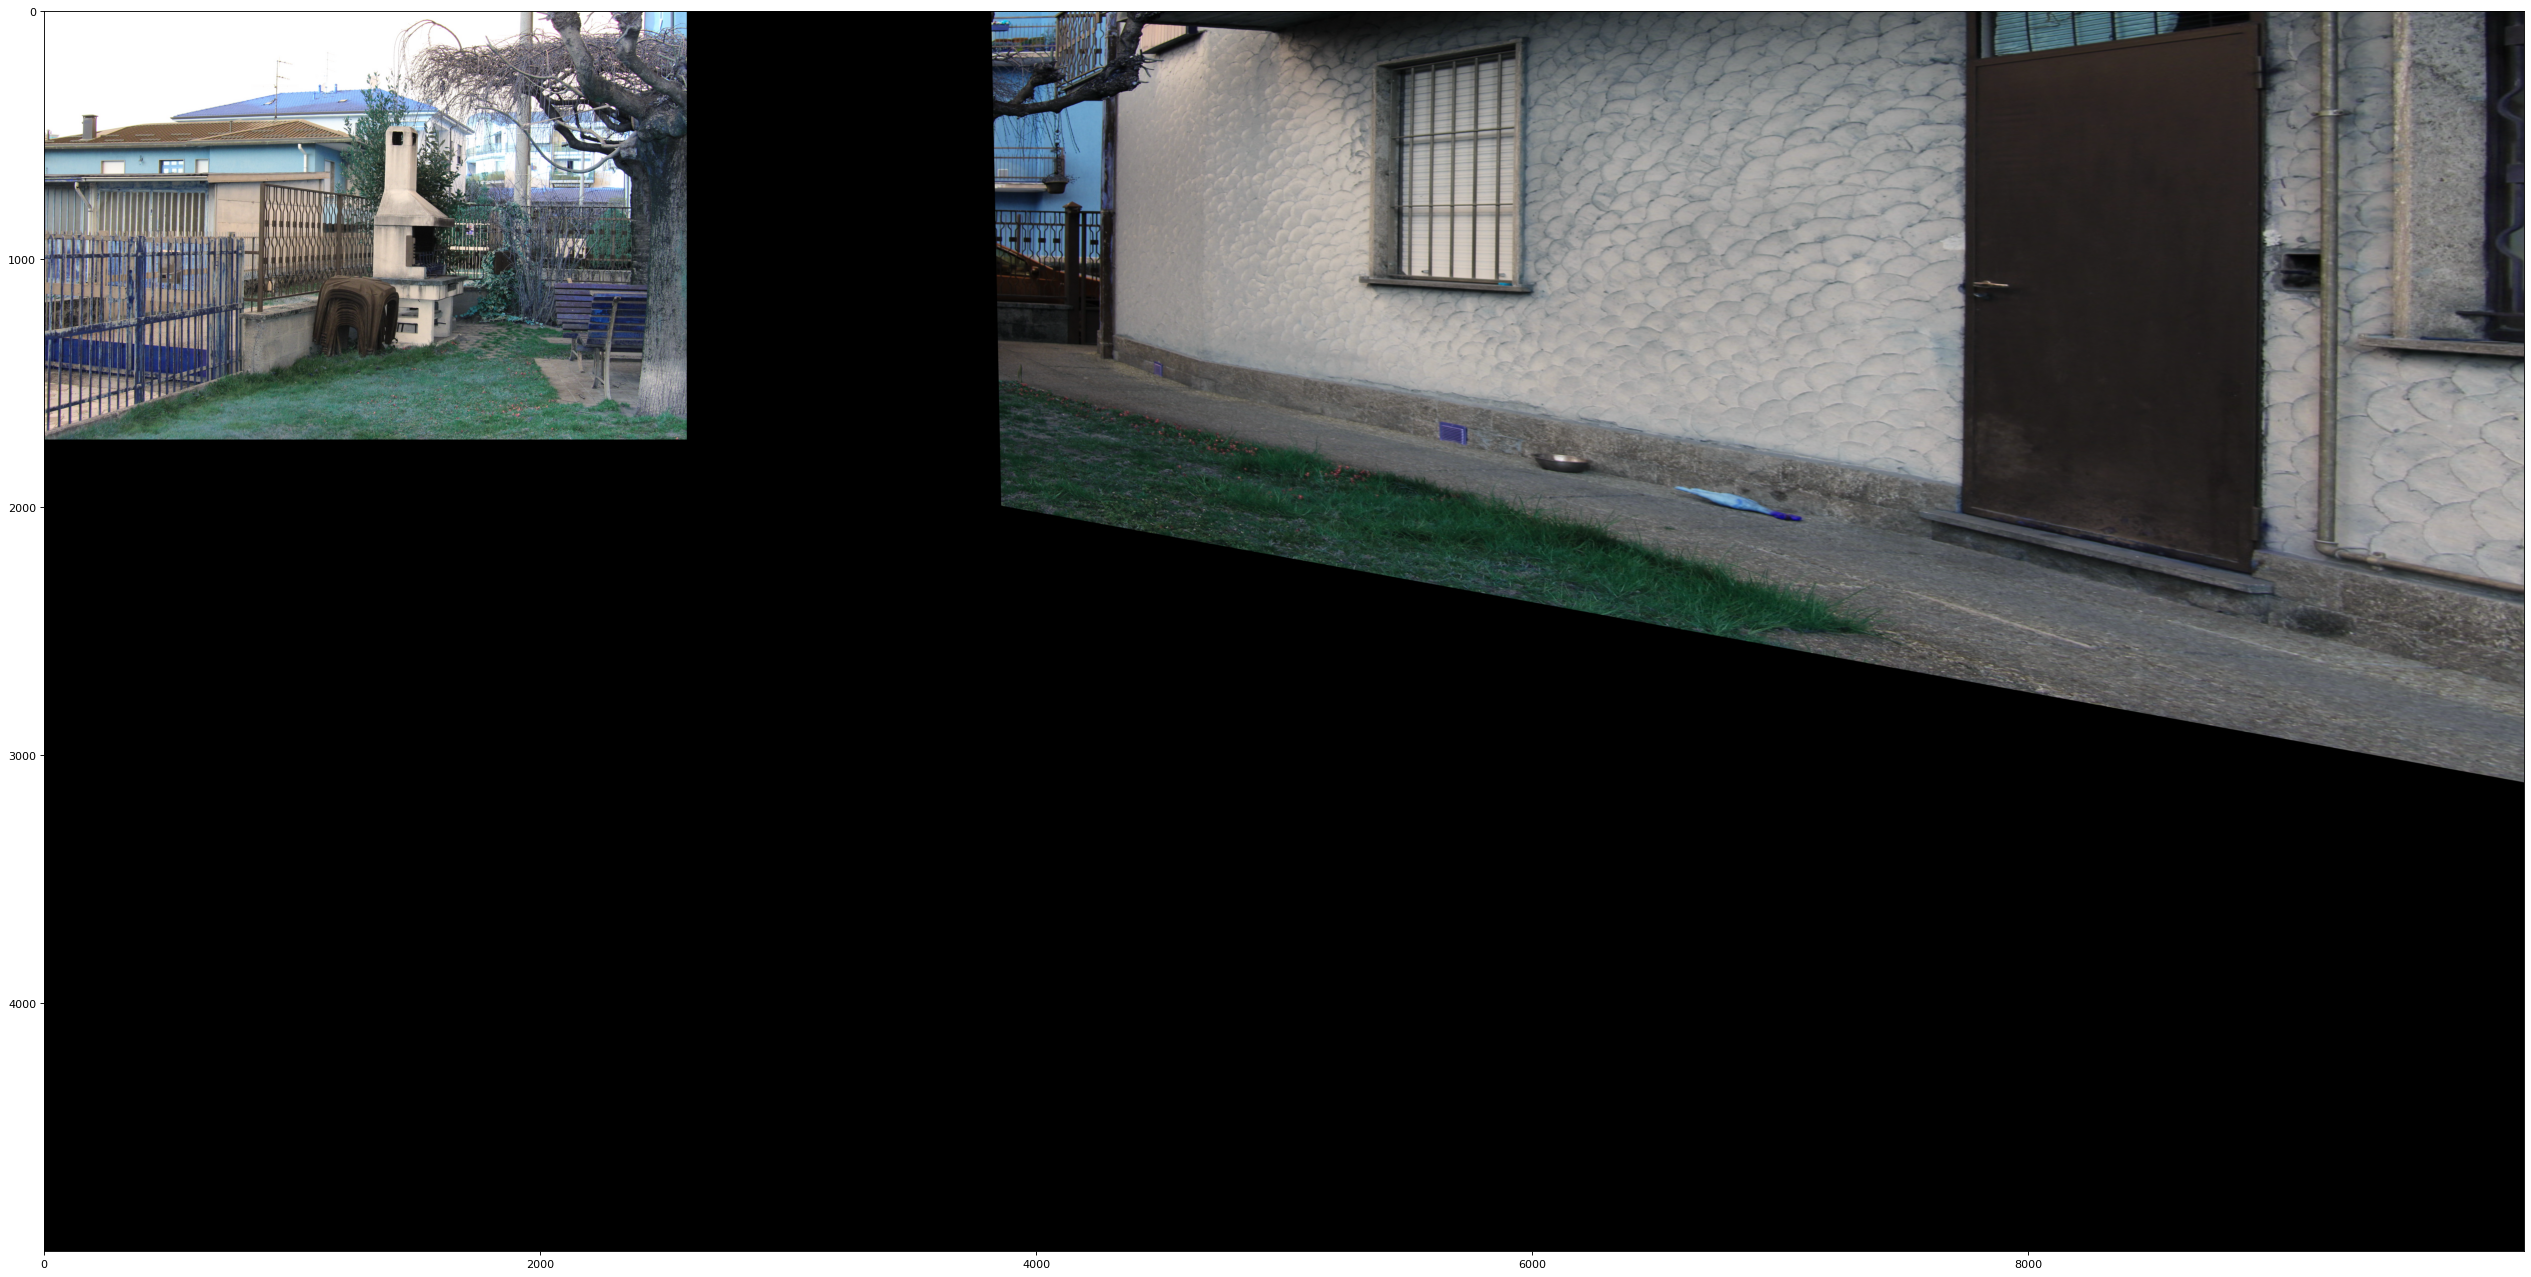

(<matplotlib.image.AxesImage at 0x162997b8940>, None)

In [396]:
from matplotlib.pyplot import figure
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show()

In [397]:
im_dst_2 = cv.warpPerspective(imgs[2], np.linalg.inv(H_new[2]), [10000,5000])

In [398]:
stitch = np.maximum(stitch,im_dst_2)

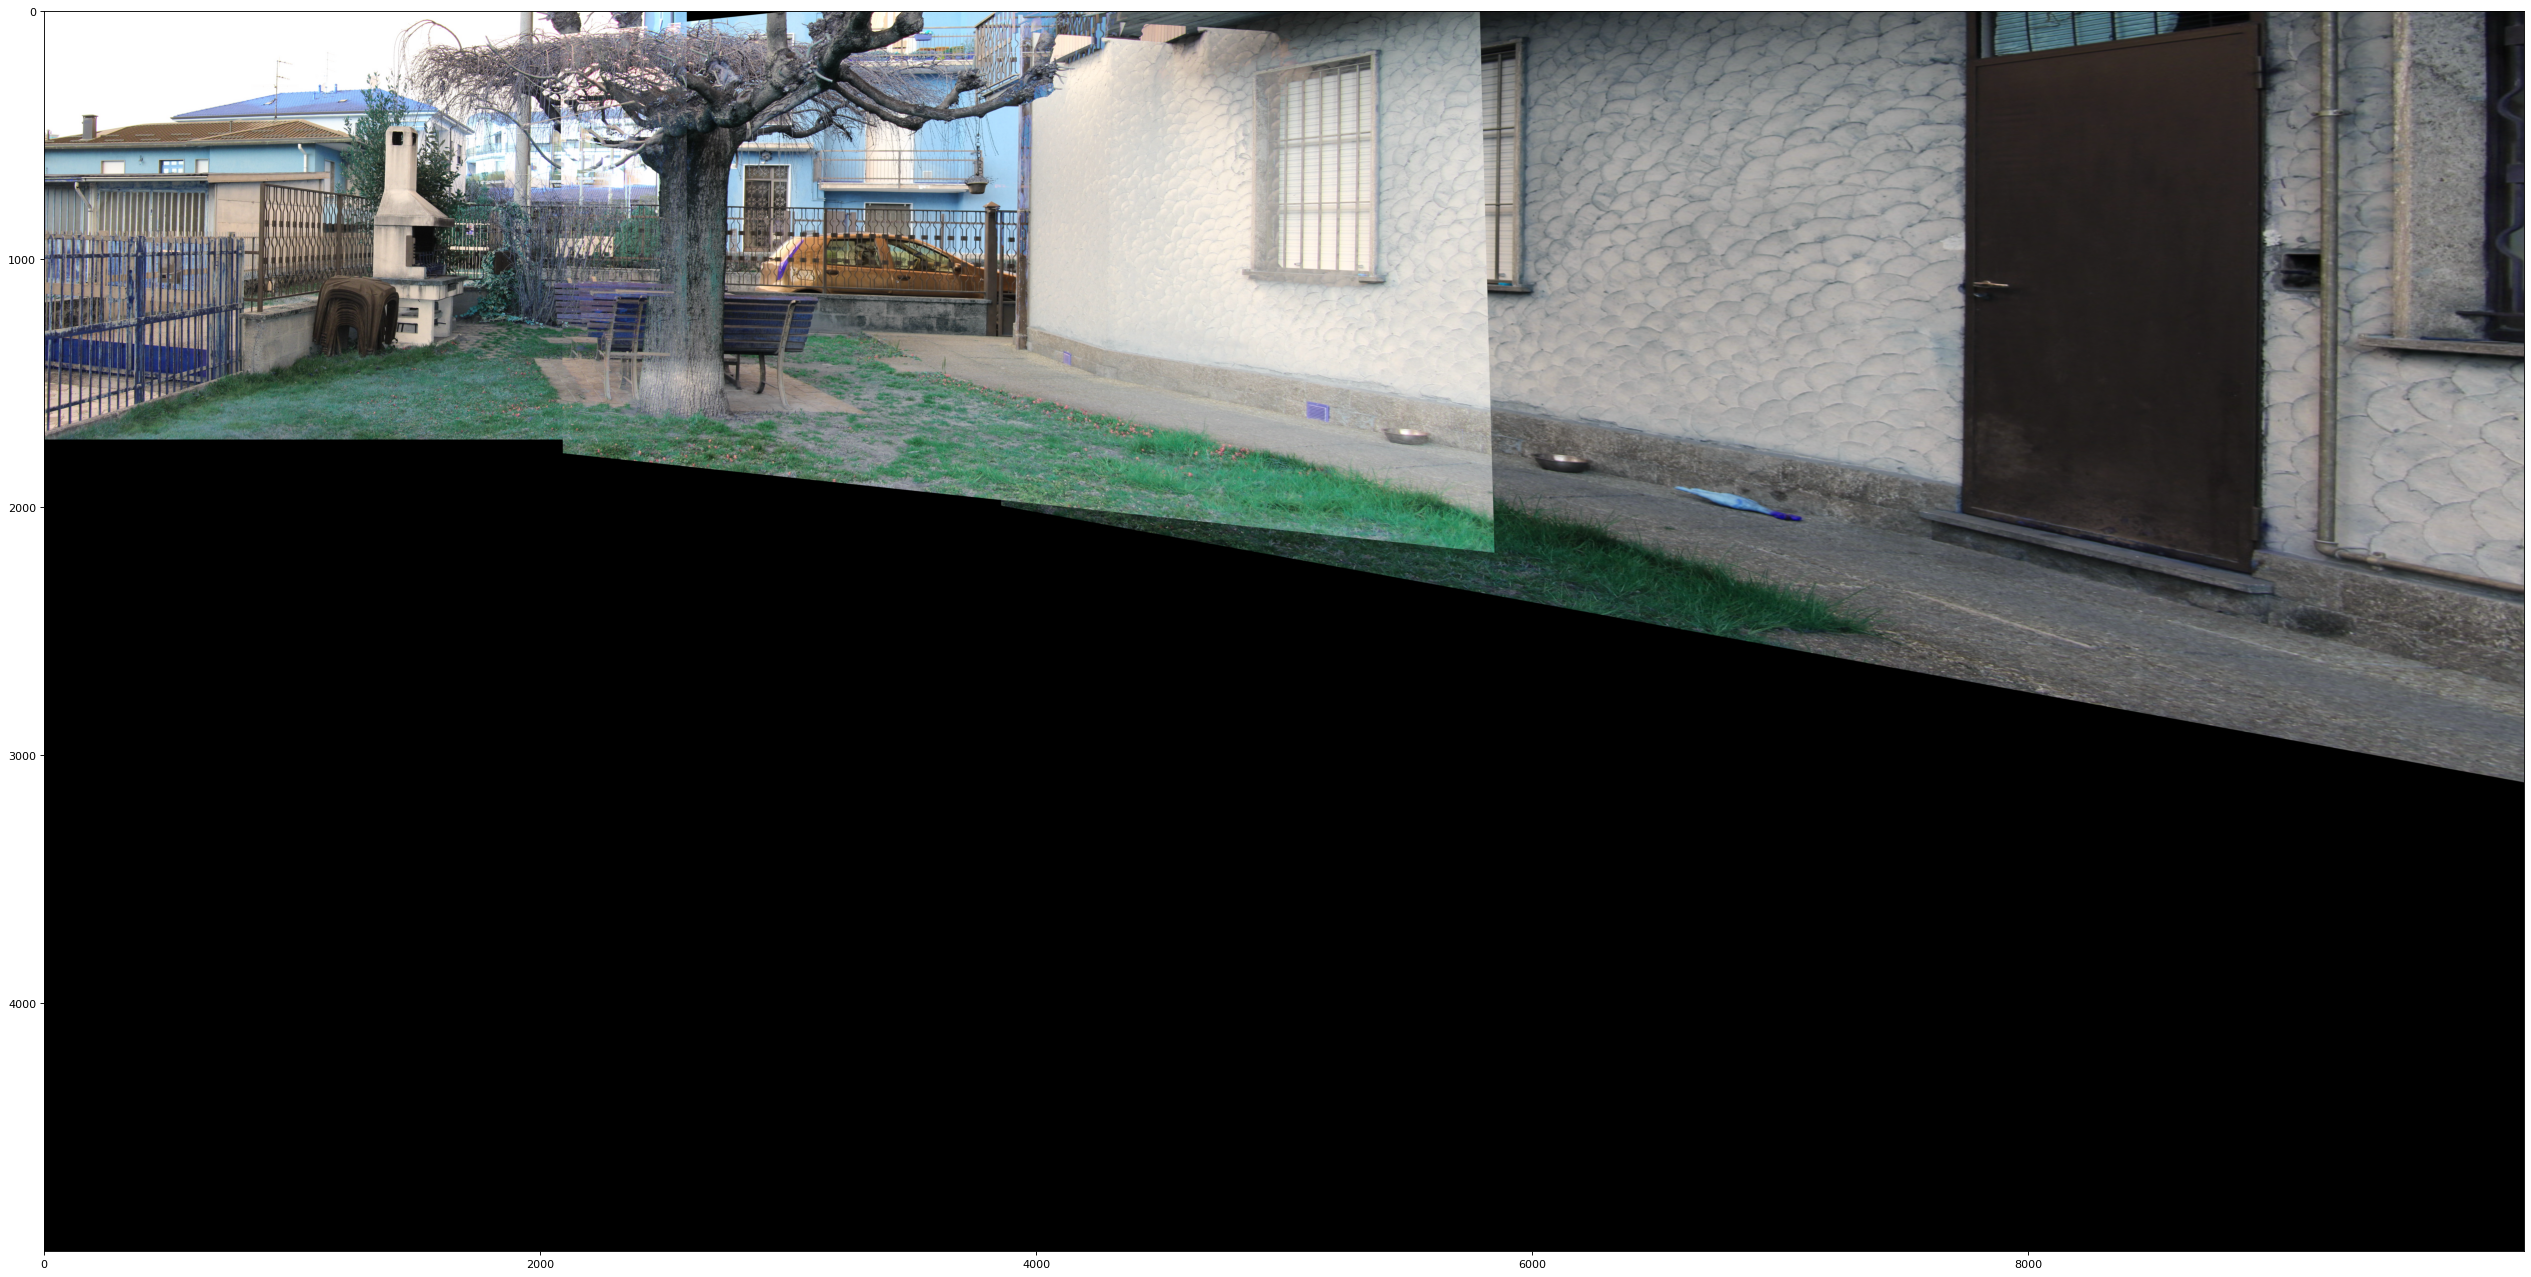

(<matplotlib.image.AxesImage at 0x1628bc5bfa0>, None)

In [399]:
from matplotlib.pyplot import figure
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch,),plt.show()